# Loading + Preprocessing + Splitting Dataset

In [5]:
import os
from pathlib import Path
import shutil
import random
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from tqdm import tqdm

DATA_DIR = '/kaggle/input/infectious-skin-lesion-dataset/Infectious Skin Lesion Dataset'
OUT_DIR = '/kaggle/working/split'
TARGET_SIZE = (224, 224)
RANDOM_STATE = 42
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

for subset in ['train', 'val', 'test']:
    os.makedirs(os.path.join(OUT_DIR, subset), exist_ok=True)

classes = sorted([p.name for p in Path(DATA_DIR).iterdir() if p.is_dir()])
print("Detected classes:", classes)

filepaths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff'):
        for p in Path(cls_dir).glob(ext):
            filepaths.append(str(p))
            labels.append(cls)

print(f"Found {len(filepaths)} images total across {len(classes)} classes.")

TEMP_CLEAN = os.path.join(OUT_DIR, 'clean')
os.makedirs(TEMP_CLEAN, exist_ok=True)

clean_filepaths = []
clean_labels = []

print("Validating images, converting to RGB and resizing (if needed)...")
for fp, lbl in tqdm(zip(filepaths, labels), total=len(filepaths)):
    try:
        with Image.open(fp) as im:
            if im.mode != 'RGB':
                im = im.convert('RGB')
            if TARGET_SIZE is not None:
                im = im.resize(TARGET_SIZE, Image.LANCZOS)
            cls_out_dir = os.path.join(TEMP_CLEAN, lbl)
            os.makedirs(cls_out_dir, exist_ok=True)
            base = os.path.splitext(os.path.basename(fp))[0]
            out_path = os.path.join(cls_out_dir, base + '.jpg')
            im.save(out_path, format='JPEG', quality=95)
            clean_filepaths.append(out_path)
            clean_labels.append(lbl)
    except (UnidentifiedImageError, OSError, ValueError) as e:
        corrupted_dir = os.path.join(OUT_DIR, 'corrupted')
        os.makedirs(corrupted_dir, exist_ok=True)
        with open(os.path.join(corrupted_dir, 'corrupted_log.txt'), 'a') as f:
            f.write(f"{fp}\t{str(e)}\n")

print(f"After cleaning: {len(clean_filepaths)} images available.")

train_files, temp_files, train_labels, temp_labels = train_test_split(
    clean_filepaths, clean_labels,
    train_size=TRAIN_RATIO,
    stratify=clean_labels,
    random_state=RANDOM_STATE
)

val_prop_of_temp = VAL_RATIO / (VAL_RATIO + TEST_RATIO)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels,
    train_size=val_prop_of_temp,
    stratify=temp_labels,
    random_state=RANDOM_STATE
)

print("Split sizes (files):")
print(" TRAIN:", len(train_files))
print(" VAL:  ", len(val_files))
print(" TEST: ", len(test_files))

def copy_into(subset_name, files_list, labels_list):
    for fp, lbl in tqdm(zip(files_list, labels_list), total=len(files_list), desc=f'Copying {subset_name}'):
        dst_dir = os.path.join(OUT_DIR, subset_name, lbl)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(fp))
        shutil.copy(fp, dst_path)

copy_into('train', train_files, train_labels)
copy_into('val', val_files, val_labels)
copy_into('test', test_files, test_labels)

# Final per-class counts
print("\nFinal distribution per class:")
for cls in classes:
    n_train = len(list(Path(os.path.join(OUT_DIR, 'train', cls)).glob('*'))) if os.path.exists(os.path.join(OUT_DIR, 'train', cls)) else 0
    n_val   = len(list(Path(os.path.join(OUT_DIR, 'val', cls)).glob('*')))   if os.path.exists(os.path.join(OUT_DIR, 'val', cls))   else 0
    n_test  = len(list(Path(os.path.join(OUT_DIR, 'test', cls)).glob('*')))  if os.path.exists(os.path.join(OUT_DIR, 'test', cls))  else 0
    print(f"{cls:45s}  train={n_train:4d}   val={n_val:4d}   test={n_test:4d}   total={n_train+n_val+n_test:5d}")

print("\nSplit directory is at:", OUT_DIR)


Detected classes: ['Cellulitis Impetigo and other Bacterial Infections', 'Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Herpes,HPV and other STD', 'Measles', 'Monkeypox', 'Scabies Lyme Disease and other Infestations and Bites', 'Tinea(Ringworm),Candidiasis and other Fungal Infections', 'Warts,Molluscum and other Viral Infections']
Found 18131 images total across 11 classes.
Validating images, converting to RGB and resizing (if needed)...


100%|██████████| 18131/18131 [01:38<00:00, 184.66it/s]


After cleaning: 18131 images available.
Split sizes (files):
 TRAIN: 12691
 VAL:   2720
 TEST:  2720


Copying test: 100%|██████████| 2720/2720 [00:00<00:00, 6040.94it/s]



Final distribution per class:
Cellulitis Impetigo and other Bacterial Infections  train= 253   val=  54   test=  54   total=  361
Chickenpox                                     train= 789   val= 169   test= 169   total= 1127
Cowpox                                         train= 670   val= 143   test= 144   total=  957
HFMD                                           train=1690   val= 363   test= 362   total= 2415
Healthy                                        train=1197   val= 256   test= 257   total= 1710
Herpes,HPV and other STD                       train= 355   val=  76   test=  76   total=  507
Measles                                        train= 577   val= 124   test= 124   total=  825
Monkeypox                                      train=2982   val= 639   test= 639   total= 4260
Scabies Lyme Disease and other Infestations and Bites  train= 377   val=  81   test=  81   total=  539
Tinea(Ringworm),Candidiasis and other Fungal Infections  train=2329   val= 499   test= 499   total= 3

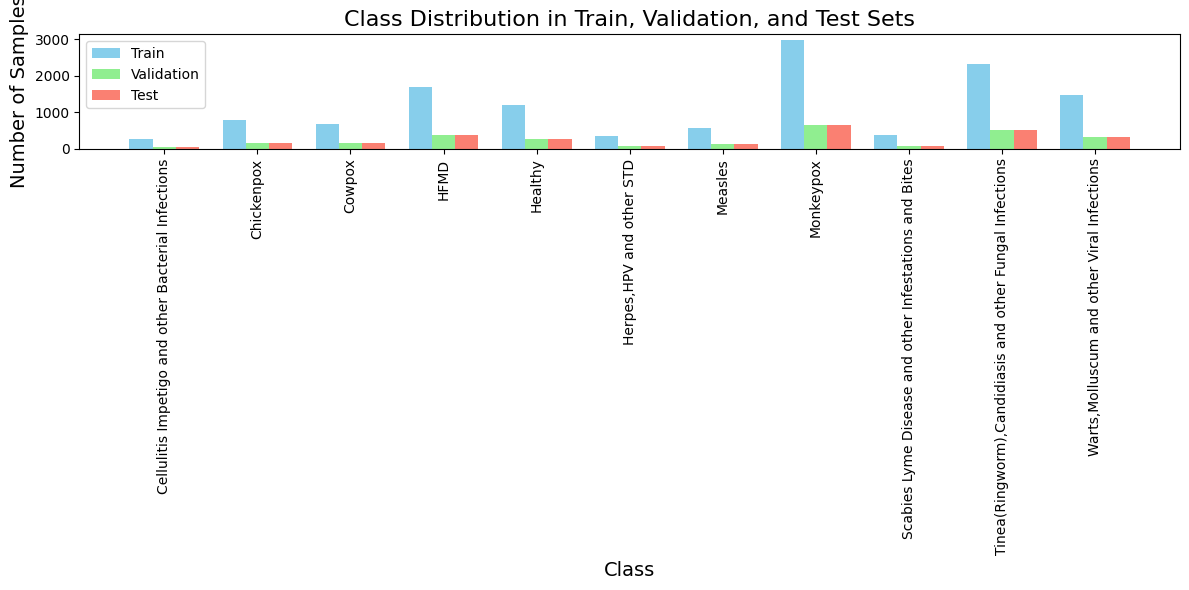

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

classes = sorted(list(set(train_counts.keys()).union(val_counts.keys(), test_counts.keys())))
train_counts_list = [train_counts.get(cls, 0) for cls in classes]
val_counts_list = [val_counts.get(cls, 0) for cls in classes]
test_counts_list = [test_counts.get(cls, 0) for cls in classes]

plt.figure(figsize=(12, 6))
x = range(len(classes))
width = 0.25

plt.bar(x, train_counts_list, width=width, label='Train', align='center', color='skyblue')
plt.bar([p + width for p in x], val_counts_list, width=width, label='Validation', align='center', color='lightgreen')
plt.bar([p + 2 * width for p in x], test_counts_list, width=width, label='Test', align='center', color='salmon')

plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Class Distribution in Train, Validation, and Test Sets', fontsize=16)
plt.xticks([p + width for p in x], classes, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Samppling

In [7]:
import os
import random
import cv2
import shutil
import numpy as np
from tqdm import tqdm
from albumentations import (
    Compose, RandomRotate90, HorizontalFlip, VerticalFlip,
    RandomBrightnessContrast, HueSaturationValue, CLAHE,
    Blur, GaussNoise, RandomResizedCrop
)

try:
    from albumentations.augmentations.dropout.coarse_dropout import CoarseDropout
except ImportError:
    try:
        from albumentations.augmentations.dropout import CoarseDropout
    except ImportError:
        from albumentations import CoarseDropout 

Cutout = CoarseDropout
train_dir = '/kaggle/working/split/train'
balanced_dir = '/kaggle/working/balanced_train'
os.makedirs(balanced_dir, exist_ok=True)
transform = Compose([
    RandomRotate90(),
    HorizontalFlip(),
    VerticalFlip(),
    RandomBrightnessContrast(p=0.5),
    HueSaturationValue(p=0.5),
    CLAHE(p=0.3),
    Blur(blur_limit=3, p=0.3),
    GaussNoise(p=0.3),
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(1.0, 1.0), p=1.0),
    Cutout(num_holes=8, max_h_size=16, max_w_size=16, fill_value=0, p=0.3)
])


IMG_SIZE = 224
class_counts = {}
for cls in sorted(os.listdir(train_dir)):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

print("Initial training class counts:")
for c, n in class_counts.items():
    print(f"{c:<70} {n}")

mean_count = int(np.mean(list(class_counts.values())))
print(f"\nMean class count ≈ {mean_count}")
def augment_image(img):
    augmented = transform(image=img)
    return augmented['image']

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

for cls, count in class_counts.items():
    src_path = os.path.join(train_dir, cls)
    dest_path = os.path.join(balanced_dir, cls)
    os.makedirs(dest_path, exist_ok=True)
    
    images = os.listdir(src_path)
    random.shuffle(images)
    
    if count > mean_count * 1.2:
        selected = images[:mean_count]
        print(f"↓ Downsampling {cls}: from {count} → {len(selected)}")
        for img_name in tqdm(selected, desc=f"Copy {cls}"):
            shutil.copy(os.path.join(src_path, img_name), os.path.join(dest_path, img_name))
    
    elif count < mean_count * 0.9:
        print(f"↑ Oversampling {cls}: from {count} → {mean_count}")
        # Copy originals first
        for img_name in images:
            shutil.copy(os.path.join(src_path, img_name), os.path.join(dest_path, img_name))
        
        extra_needed = mean_count - count
        for i in tqdm(range(extra_needed), desc=f"Augment {cls}"):
            img_path = os.path.join(src_path, random.choice(images))
            img = load_image(img_path)
            if img is not None:
                aug_img = augment_image(img)
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                save_path = os.path.join(dest_path, f"aug_{i}.jpg")
                cv2.imwrite(save_path, aug_img)
    
    else:
        for img_name in tqdm(images, desc=f"Copy {cls}"):
            shutil.copy(os.path.join(src_path, img_name), os.path.join(dest_path, img_name))

print("\nFinal class distribution:")
for cls in sorted(os.listdir(balanced_dir)):
    n = len(os.listdir(os.path.join(balanced_dir, cls)))
    print(f"{cls:<70} {n}")

print("\nBalancing and augmentation complete!")
print("Balanced data saved at:", balanced_dir)


/tmp/ipykernel_48/4029887436.py:35: UserWarning: Argument(s) 'num_holes, max_h_size, max_w_size, fill_value' are not valid for transform CoarseDropout
  Cutout(num_holes=8, max_h_size=16, max_w_size=16, fill_value=0, p=0.3)


Initial training class counts:
Cellulitis Impetigo and other Bacterial Infections                     253
Chickenpox                                                             789
Cowpox                                                                 670
HFMD                                                                   1690
Healthy                                                                1197
Herpes,HPV and other STD                                               355
Measles                                                                577
Monkeypox                                                              2982
Scabies Lyme Disease and other Infestations and Bites                  377
Tinea(Ringworm),Candidiasis and other Fungal Infections                2329
Warts,Molluscum and other Viral Infections                             1472

Mean class count ≈ 1153
↑ Oversampling Cellulitis Impetigo and other Bacterial Infections: from 253 → 1153


Augment Cellulitis Impetigo and other Bacterial Infections: 100%|██████████| 900/900 [00:03<00:00, 288.19it/s]


↑ Oversampling Chickenpox: from 789 → 1153


Augment Chickenpox: 100%|██████████| 364/364 [00:01<00:00, 296.98it/s]


↑ Oversampling Cowpox: from 670 → 1153


Augment Cowpox: 100%|██████████| 483/483 [00:01<00:00, 273.70it/s]


↓ Downsampling HFMD: from 1690 → 1153


Copy Healthy: 100%|██████████| 1197/1197 [00:00<00:00, 8894.28it/s]


↑ Oversampling Herpes,HPV and other STD: from 355 → 1153


Augment Herpes,HPV and other STD: 100%|██████████| 798/798 [00:02<00:00, 293.45it/s]


↑ Oversampling Measles: from 577 → 1153


Augment Measles: 100%|██████████| 576/576 [00:01<00:00, 310.45it/s]


↓ Downsampling Monkeypox: from 2982 → 1153


Copy Monkeypox: 100%|██████████| 1153/1153 [00:00<00:00, 9691.95it/s]


↑ Oversampling Scabies Lyme Disease and other Infestations and Bites: from 377 → 1153


Augment Scabies Lyme Disease and other Infestations and Bites: 100%|██████████| 776/776 [00:02<00:00, 316.79it/s]


↓ Downsampling Tinea(Ringworm),Candidiasis and other Fungal Infections: from 2329 → 1153


Copy Tinea(Ringworm),Candidiasis and other Fungal Infections: 100%|██████████| 1153/1153 [00:00<00:00, 9008.55it/s]


↓ Downsampling Warts,Molluscum and other Viral Infections: from 1472 → 1153


Copy Warts,Molluscum and other Viral Infections: 100%|██████████| 1153/1153 [00:00<00:00, 8329.89it/s]


Final class distribution:
Cellulitis Impetigo and other Bacterial Infections                     1153
Chickenpox                                                             1153
Cowpox                                                                 1153
HFMD                                                                   1153
Healthy                                                                1197
Herpes,HPV and other STD                                               1153
Measles                                                                1153
Monkeypox                                                              1153
Scabies Lyme Disease and other Infestations and Bites                  1153
Tinea(Ringworm),Candidiasis and other Fungal Infections                1153
Warts,Molluscum and other Viral Infections                             1153

Balancing and augmentation complete!
Balanced data saved at: /kaggle/working/balanced_train


# Approach 1 - Model Training

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

train_dir = '/kaggle/working/balanced_train'
val_dir = '/kaggle/working/split/val'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-20]:   # keep last 20 layers trainable
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(11, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

checkpoint = ModelCheckpoint(
    '/kaggle/working/best_mobilenetv2_model_a1.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

EPOCHS = 100
history_mobilenet_a1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

model.save('/kaggle/working/final_mobilenetv2_model_a1.keras')
print("Model saved successfully!")


Found 14618 images belonging to 11 classes.
Found 2720 images belonging to 11 classes.
Epoch 1/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.3899 - loss: 1.7643 - precision: 0.6143 - recall: 0.1826
Epoch 1: val_loss improved from inf to 1.56409, saving model to /kaggle/working/best_mobilenetv2_model_a1.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 167s 338ms/step - accuracy: 0.3901 - loss: 1.7636 - precision: 0.6145 - recall: 0.1828 - val_accuracy: 0.5368 - val_loss: 1.5641 - val_precision: 0.5790 - val_recall: 0.4875 - learning_rate: 1.0000e-04
Epoch 2/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6385 - loss: 1.0113 - precision: 0.7684 - recall: 0.5000
Epoch 2: val_loss improved from 1.56409 to 1.13651, saving model to /kaggle/working/best_mobilenetv2_model_a1.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 144s 315ms/step - accuracy: 0.6385 - loss: 1.0113 - precision: 0.7684 - recall: 0.5001 - val_accuracy: 0.6548 - val_loss: 1.1365 - val_precision: 0.6838 - val_recall: 0.6257

In [14]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 5,662,435 (21.60 MB)

 Trainable params: 1,536,843 (5.86 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 3,073,688 (11.73 MB)

# Evaluation for Approach 1

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_dir = '/kaggle/working/split/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")
print(f" Test Precision: {test_precision*100:.2f}%")
print(f" Test Recall: {test_recall*100:.2f}%")

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Found 2720 images belonging to 11 classes.
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8344 - loss: 0.7007 - precision: 0.8446 - recall: 0.8280
 Test Accuracy: 86.84%
 Test Loss: 0.4858
 Test Precision: 88.18%
 Test Recall: 86.14%
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step

📊 Classification Report:
                                                         precision    recall  f1-score   support

     Cellulitis Impetigo and other Bacterial Infections       0.38      0.17      0.23        54
                                             Chickenpox       0.92      0.85      0.89       169
                                                 Cowpox       0.95      0.96      0.95       144
                                                   HFMD       0.97      0.97      0.97       362
                                                Healthy       0.95      0.97      0.96       257
                               Herpes,HPV and other STD       0.53      0.28      0.36        76
             

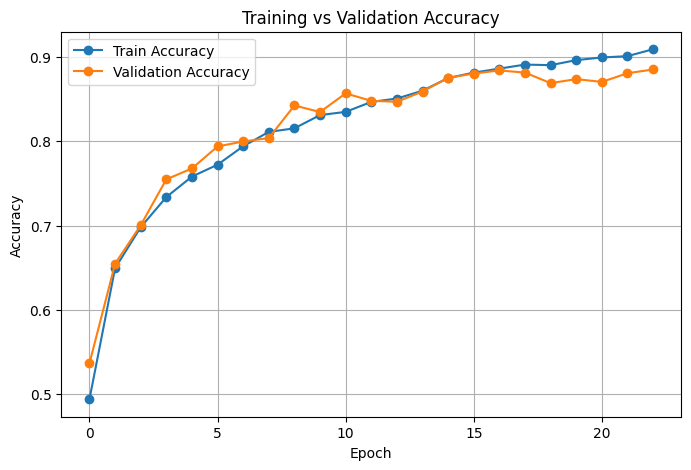

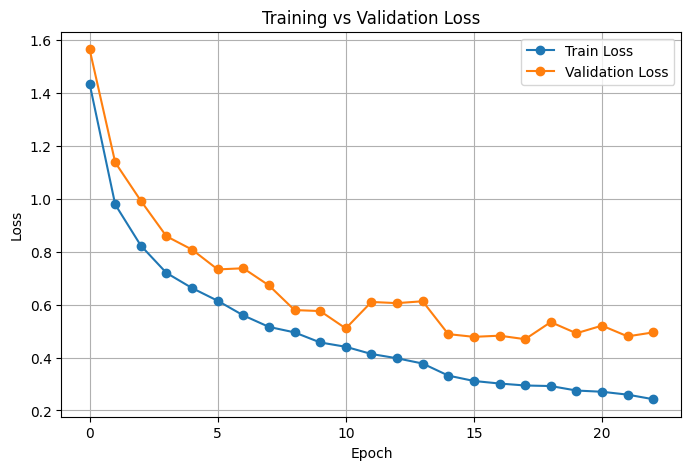

In [15]:
import matplotlib.pyplot as plt
history=history_mobilenet_a1
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


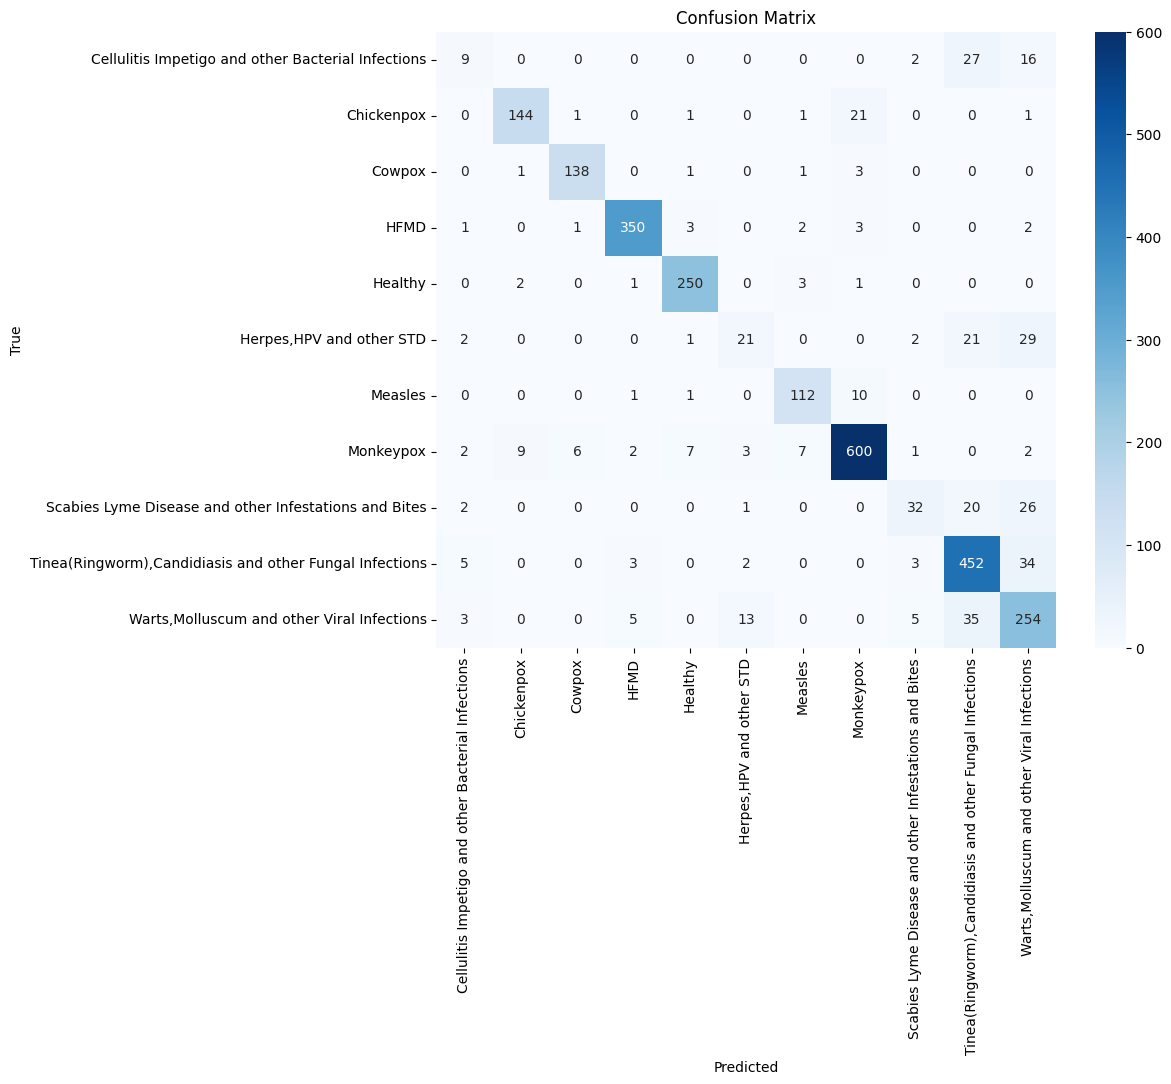

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


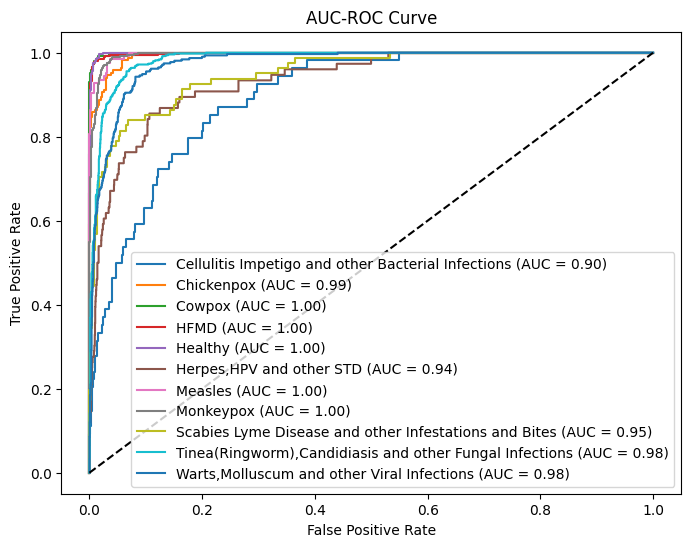

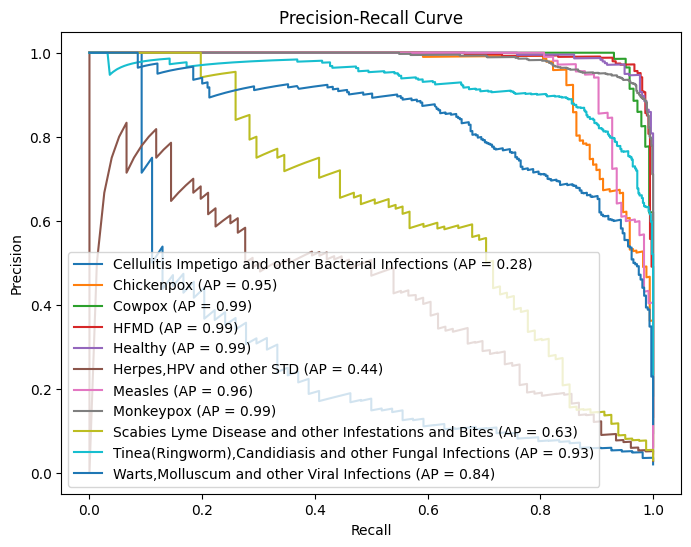

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
import numpy as np

y_true = test_generator.classes
y_pred_proba = model.predict(test_generator)
n_classes = y_pred_proba.shape[1]

y_true_onehot = to_categorical(y_true, num_classes=n_classes)

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_true_onehot[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'{list(test_generator.class_indices.keys())[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Approach 2 - Model Training

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

tf.get_logger().setLevel('ERROR')

train_dir = '/kaggle/working/balanced_train'
val_dir = '/kaggle/working/split/val'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False


x = base_model.output
x = Flatten()(x)  
x = Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(11, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

initial_lr = 1e-4
optimizer = Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

checkpoint = ModelCheckpoint(
    '/kaggle/working/best_mobilenetv2_model_a2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

EPOCHS = 100
history_mobilenet_a2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint, early_stop, reduce_lr, tf.keras.callbacks.LearningRateScheduler(lr_schedule)],
)

model.save('/kaggle/working/final_mobilenetv2_model_a2.keras') 
print("Model saved successfully!")


Found 14618 images belonging to 11 classes.
Found 2720 images belonging to 11 classes.
Epoch 1/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.1948 - loss: 39.5432 - precision: 0.2434 - recall: 0.0971
Epoch 1: val_loss improved from inf to 33.30620, saving model to /kaggle/working/best_mobilenetv2_model_a2.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 182s 356ms/step - accuracy: 0.1950 - loss: 39.5390 - precision: 0.2436 - recall: 0.0972 - val_accuracy: 0.5449 - val_loss: 33.3062 - val_precision: 0.6130 - val_recall: 0.4566 - learning_rate: 1.0000e-04
Epoch 2/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.4010 - loss: 32.1152 - precision: 0.5118 - recall: 0.2798
Epoch 2: val_loss improved from 33.30620 to 26.64675, saving model to /kaggle/working/best_mobilenetv2_model_a2.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 150s 328ms/step - accuracy: 0.4011 - loss: 32.1114 - precision: 0.5119 - recall: 0.2799 - val_accuracy: 0.6169 - val_loss: 26.6467 - val_precision: 0.6529 - val_recal

In [21]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 200,076,387 (763.23 MB)

 Trainable params: 66,446,987 (253.48 MB)

 Non-trainable params: 735,424 (2.81 MB)

 Optimizer params: 132,893,976 (506.95 MB)

# Evaluation for Approach 2

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_dir = '/kaggle/working/split/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")
print(f" Test Precision: {test_precision*100:.2f}%")
print(f" Test Recall: {test_recall*100:.2f}%")

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Found 2720 images belonging to 11 classes.
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8175 - loss: 3.7610 - precision: 0.8339 - recall: 0.7983
 Test Accuracy: 85.44%
 Test Loss: 3.6173
 Test Precision: 87.70%
 Test Recall: 83.38%
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step

📊 Classification Report:
                                                         precision    recall  f1-score   support

     Cellulitis Impetigo and other Bacterial Infections       0.40      0.11      0.17        54
                                             Chickenpox       0.88      0.85      0.86       169
                                                 Cowpox       0.99      0.92      0.95       144
                                                   HFMD       0.94      0.96      0.95       362
                                                Healthy       0.93      0.96      0.95       257
                               Herpes,HPV and other STD       0.55      0.24      0.33        76
             

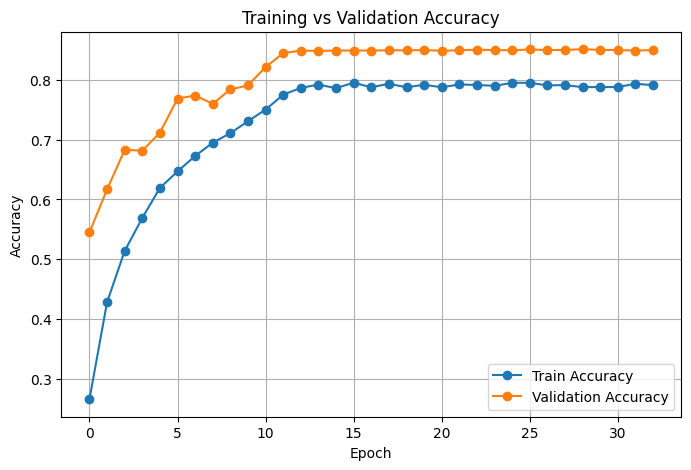

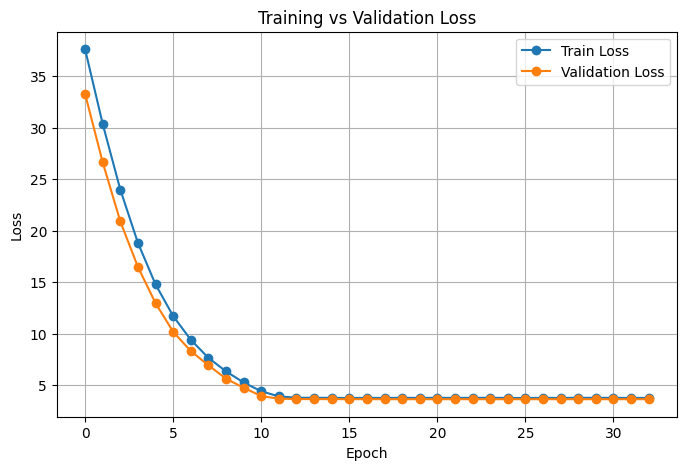

In [22]:
import matplotlib.pyplot as plt
history=history_mobilenet_a2
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


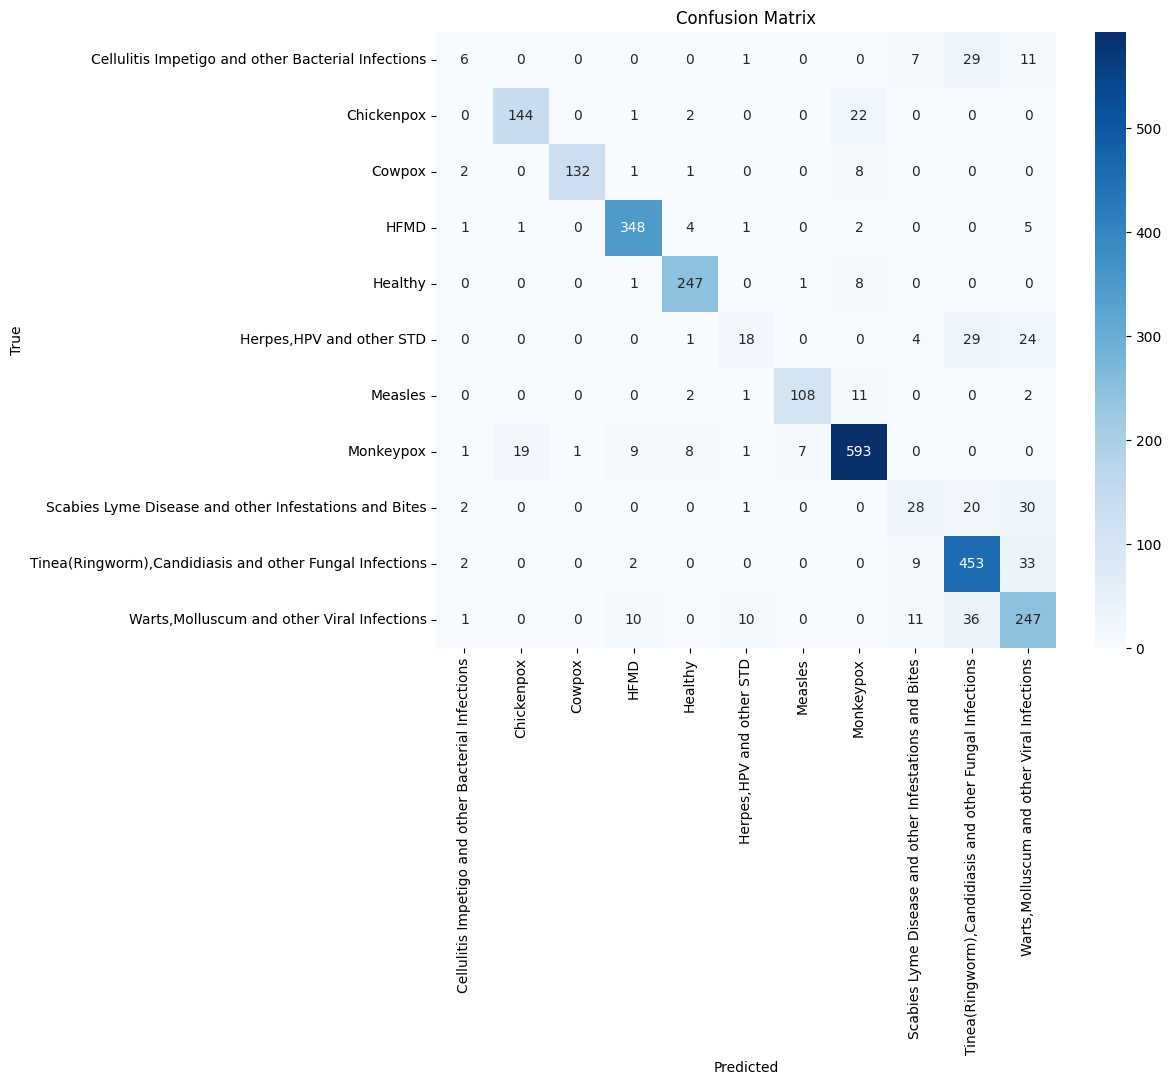

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


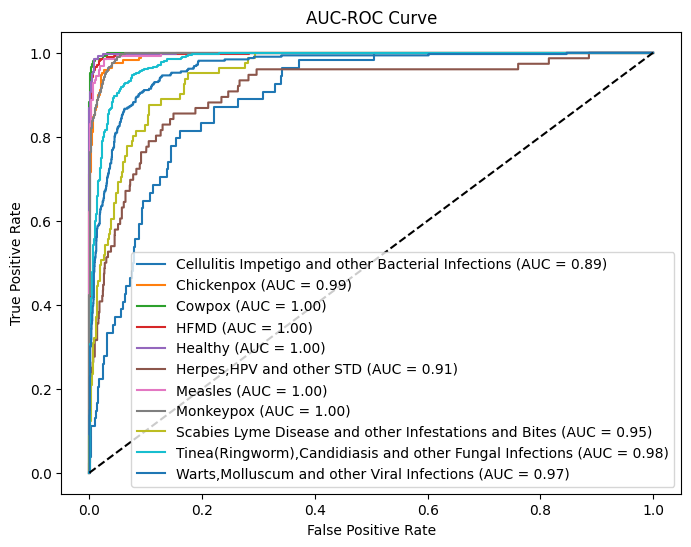

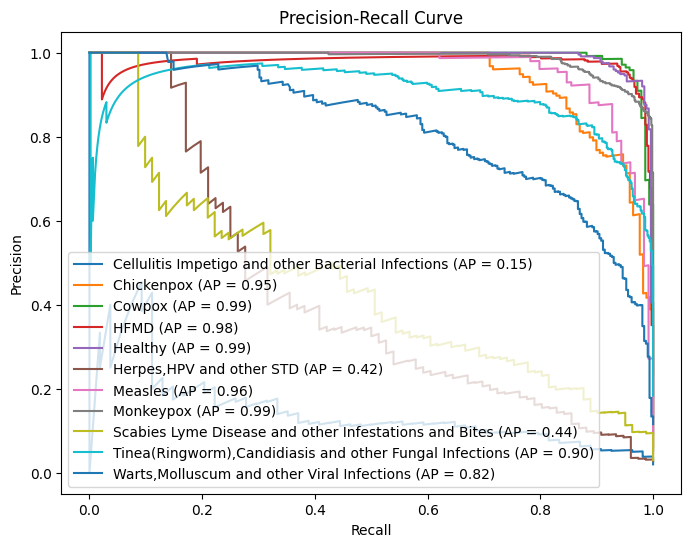

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
import numpy as np

y_true = test_generator.classes
y_pred_proba = model.predict(test_generator)  # predicted probabilities
n_classes = y_pred_proba.shape[1]

y_true_onehot = to_categorical(y_true, num_classes=n_classes)

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_true_onehot[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'{list(test_generator.class_indices.keys())[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Approach 3 - Model Training

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

tf.get_logger().setLevel('ERROR')

train_dir = '/kaggle/working/balanced_train'
val_dir = '/kaggle/working/split/val'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2  
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)  
x = Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate

x = Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate

x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
x = BatchNormalization()(x)

output = Dense(11, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

initial_lr = 1e-3  
optimizer = Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

checkpoint = ModelCheckpoint(
    '/kaggle/working/best_mobilenetv2_model_a3.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

def lr_schedule(epoch, lr):
    if epoch > 50:
        return lr * 0.5 
    return lr

EPOCHS = 100 
history_mobilenet_a3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint, early_stop, reduce_lr, tf.keras.callbacks.LearningRateScheduler(lr_schedule)],
)

model.save('/kaggle/working/final_mobilenetv2_model_a3.keras') 
print("Model saved successfully!")


Found 12727 images belonging to 11 classes.
Found 2720 images belonging to 11 classes.
Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.2441 - loss: 505.3563 - precision: 0.3554 - recall: 0.1076
Epoch 1: val_loss improved from inf to 128.21159, saving model to /kaggle/working/best_mobilenetv2_model_a3.keras
398/398 ━━━━━━━━━━━━━━━━━━━━ 165s 371ms/step - accuracy: 0.2443 - loss: 504.7110 - precision: 0.3557 - recall: 0.1077 - val_accuracy: 0.4283 - val_loss: 128.2116 - val_precision: 0.3004 - val_recall: 0.0915 - learning_rate: 0.0010
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.4365 - loss: 119.6700 - precision: 0.6008 - recall: 0.2687
Epoch 2: val_loss improved from 128.21159 to 110.72090, saving model to /kaggle/working/best_mobilenetv2_model_a3.keras
398/398 ━━━━━━━━━━━━━━━━━━━━ 133s 335ms/step - accuracy: 0.4366 - loss: 119.6594 - precision: 0.6008 - recall: 0.2688 - val_accuracy: 0.1864 - val_loss: 110.7209 - val_precision: 0.2268 - val_

In [15]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 199,980,899 (762.87 MB)

 Trainable params: 66,415,243 (253.35 MB)

 Non-trainable params: 735,168 (2.80 MB)

 Optimizer params: 132,830,488 (506.71 MB)

# Evaluation for Approach 3

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_dir = '/kaggle/working/split/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")
print(f" Test Precision: {test_precision*100:.2f}%")
print(f" Test Recall: {test_recall*100:.2f}%")

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Found 2720 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8399 - loss: 0.8171 - precision: 0.8491 - recall: 0.8322
 Test Accuracy: 87.43%
 Test Loss: 0.6256
 Test Precision: 88.39%
 Test Recall: 86.73%
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step

📊 Classification Report:
                                                         precision    recall  f1-score   support

     Cellulitis Impetigo and other Bacterial Infections       0.75      0.22      0.34        54
                                             Chickenpox       0.91      0.85      0.87       169
                                                 Cowpox       0.97      0.95      0.96       144
                                                   HFMD       0.96      0.96      0.96       362
                                                Healthy       0.91      0.99      0.95       257
                               Herpes,HPV and other STD       0.59      0.34      0.43        76
                                                Measles 

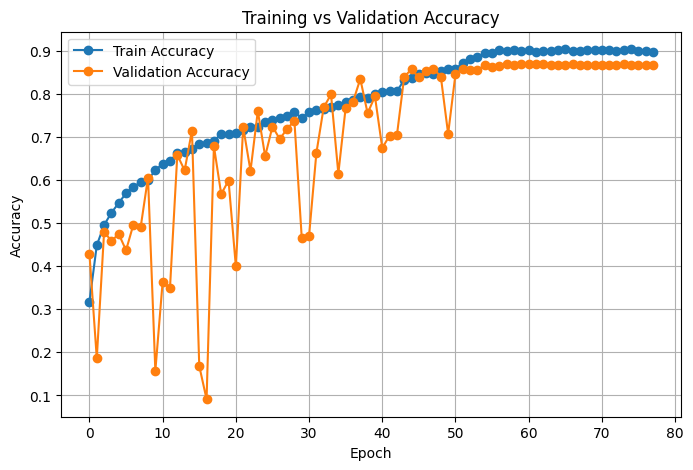

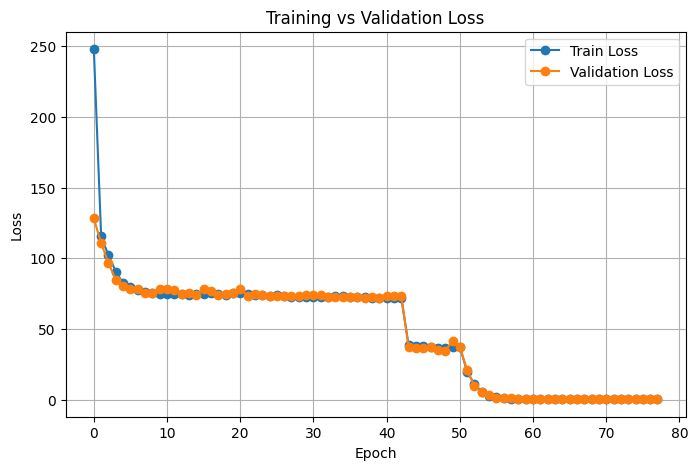

In [19]:
import matplotlib.pyplot as plt
history=history_mobilenet_a3
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


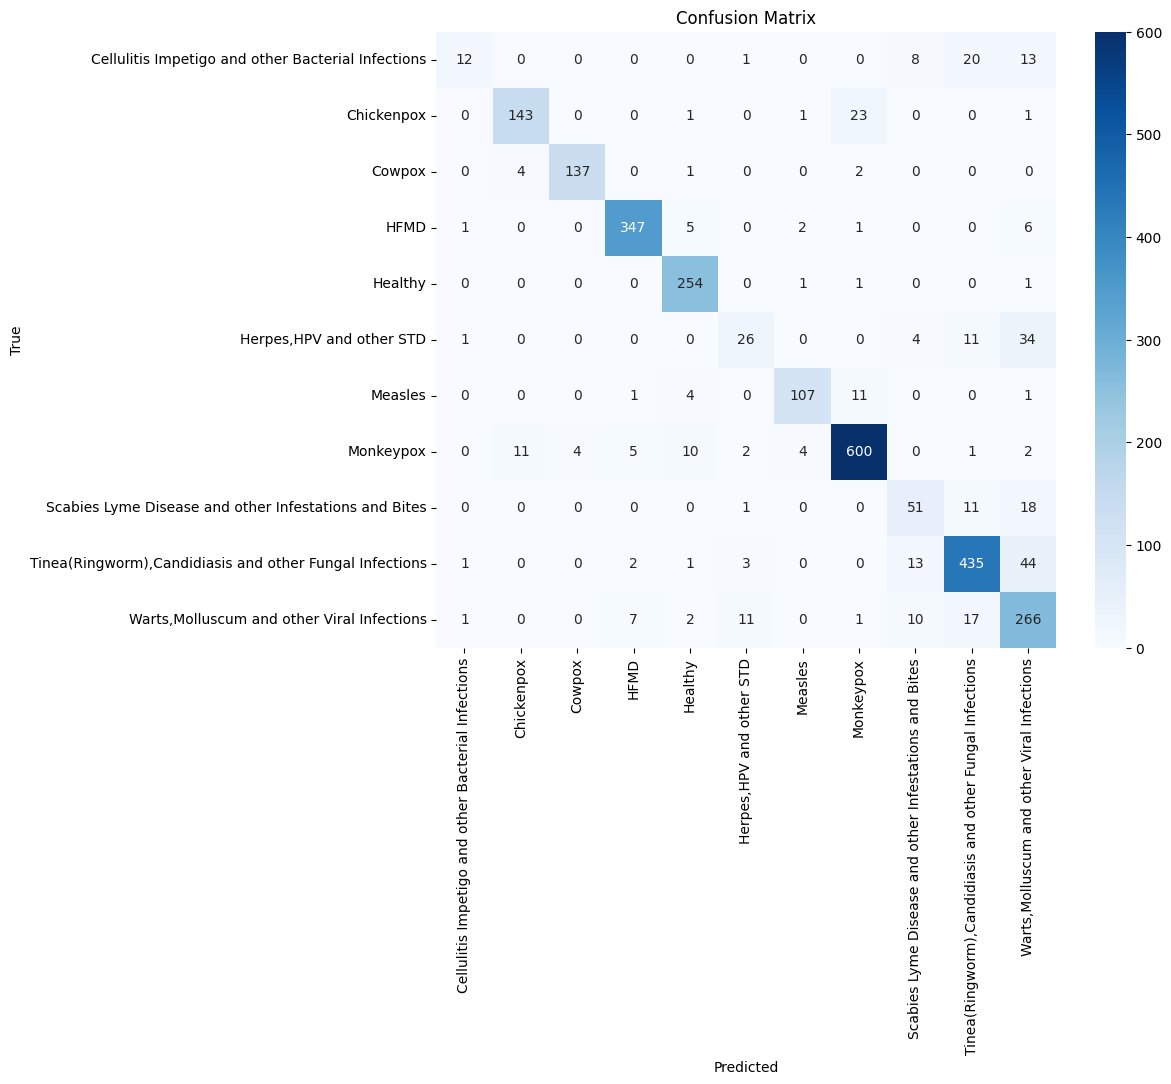

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


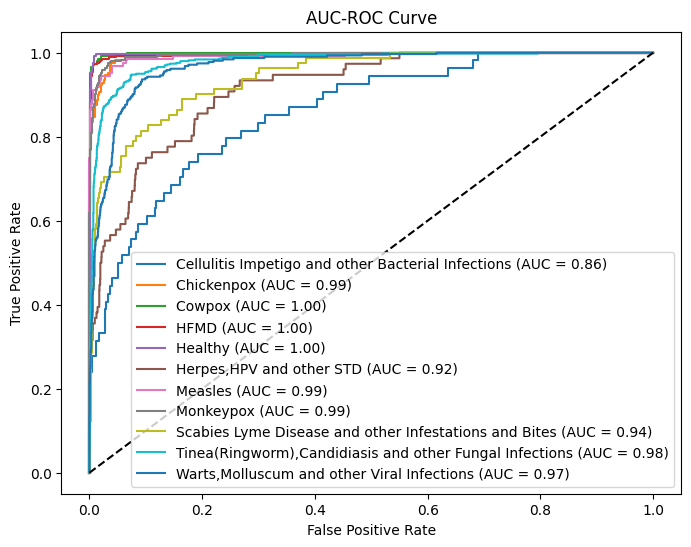

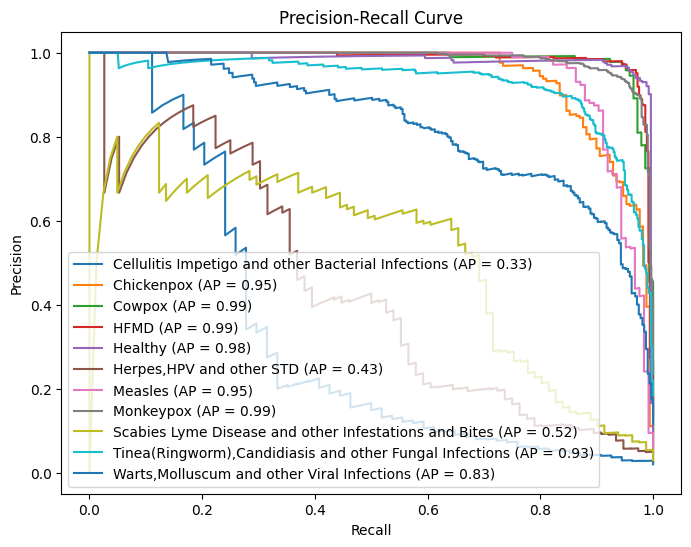

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
import numpy as np

y_true = test_generator.classes
y_pred_proba = model.predict(test_generator)  # predicted probabilities
n_classes = y_pred_proba.shape[1]

y_true_onehot = to_categorical(y_true, num_classes=n_classes)

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_true_onehot[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'{list(test_generator.class_indices.keys())[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Testing model (approach 3)

Please upload your image (or type 'exit' to stop):  /kaggle/input/skin-lesion-testing/Cowpox.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The image belongs to the class: Cowpox


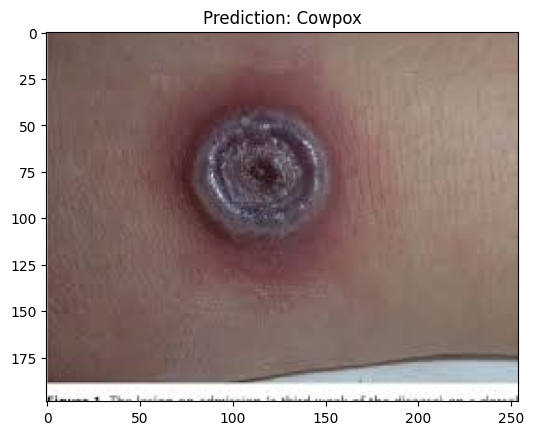

Please upload your image (or type 'exit' to stop):  /kaggle/input/skin-lesion-testing/HFMD.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The image belongs to the class: HFMD


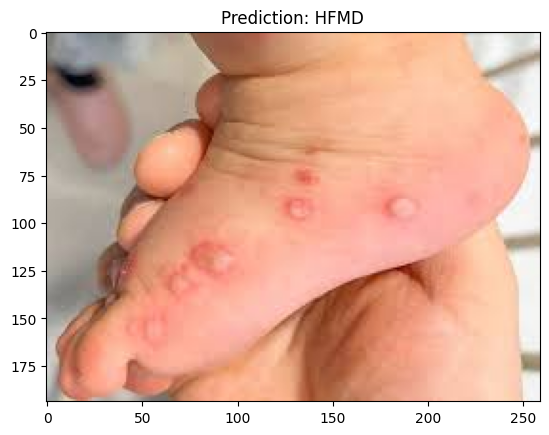

Please upload your image (or type 'exit' to stop):  /kaggle/input/skin-lesion-testing/Measles.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
The image belongs to the class: Measles


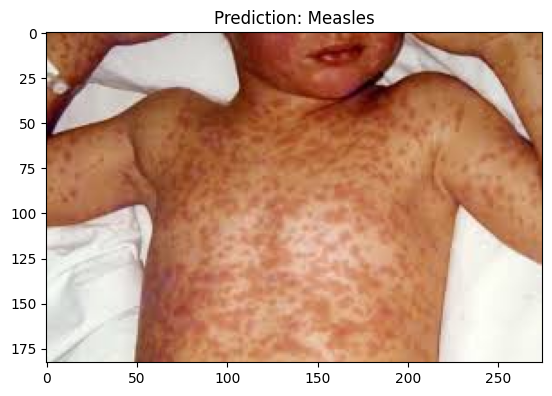

Please upload your image (or type 'exit' to stop):  exit


Exiting the program.


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

model_path = '/kaggle/working/final_mobilenetv2_model_a3.keras'  
model = tf.keras.models.load_model(model_path)

class_labels = [
    'Cellulitis Impetigo and other Bacterial Infections',
    'Chickenpox',
    'Cowpox',
    'HFMD',
    'Healthy',
    'Herpes, HPV and other STD',
    'Measles',
    'Monkeypox',
    'Scabies Lyme Disease and other Infestations and Bites',
    'Tinea(Ringworm), Candidiasis and other Fungal Infections',
    'Warts, Molluscum and other Viral Infections'
]

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    
    prediction = model.predict(img_array)
    
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    
    return predicted_class

while True:
    try:
        image_path = input("Please upload your image (or type 'exit' to stop): ")
        
        if image_path.lower() == 'exit':
            print("Exiting the program.")
            break
        
        if not os.path.exists(image_path):
            print(f"Image at {image_path} does not exist. Please try again.")
            continue
        
        predicted_class = predict_image(image_path)

        print(f"The image belongs to the class: {predicted_class}")
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}")
        plt.show()

    except Exception as e:
        print(f"Error occurred: {e}")
        continue
